**Vector-Quantized Variational Autoencoder (VQ-VAE)**

<img src="https://drive.google.com/uc?id=1yU3x4R2kBQCxUmUy2NzYjhQhRBi2ljpb" width="1000"/>

original paper: [Neural Discrete Representation Learning (2017)](https://arxiv.org/abs/1711.00937)

notebook explained & made by: [**Anas Aldadi**](https://github.com/AnasKAN)

[open on colab](https://colab.research.google.com/drive/1TzwFDzmmQD9uTG1aYrB09yTcY3_9SDaQ?usp=sharing)

---

VQ-VAEs simply put have a discrete latent space in other words it means the encoder output discrete codes (removing the property of having infinite possible latent vectors) unlike VAEs which have continuous latent space, and the prior is learnt rather than being static.

But Why? and how would we achieve that?

For the why, VQ-VAE came to solve the issue of "posterior collapse" which VAEs with powerful decoders suffer from, the decoder simply ignore the latents (the changes in latent space doesn't influence the generation).

Not only that, it is the first archeticture that offers discrete latent space, and utilize the latent space better than previous discretizing attempts, because it provides similar results to the continuous counterpart.

a direct qoutation from the paper on the contributions of this archeticture:

<img src="https://drive.google.com/uc?id=1Qg7gZtXihRLSEJ5DB0U46OD4McYgKNlQ" width="1000"/>

---

**Approach**

I'll explain each component in details in this section:

<img src="https://drive.google.com/uc?id=1gwzB-59J5YG5Bsr0Ktae0xHqOuCMuJMt" width="1000"/>

Figure 3: The whole archeticture.

As the figure illustrates the archeticture consists of 3 trainable components namely the encoder, the decoder and the codebook.

<img src="https://drive.google.com/uc?id=1xP1HJBx4h71Il4xzrDXUS0-rorN_G2Hb" width="700"/>

Figure 4: The encoder

The encoder takes the image let's say 64,64,3 and compress it into a latent continuous space let's say 4,4,64.

The encoder can be built using Conv layers, MLP layers, RNN layers, or Transformer layers it really up to you.

<img src="https://drive.google.com/uc?id=18-WPL_rVPPsu8md61OeCYGLJb0blSTtq" width="700"/>

Figure 5: The Vector Quantizer

The codebook is defined with two parameters the dimension of the latent space $D$ (which is exactly the number of kernels/filters in the last encoder layer), and the number of latent vectors/codewords $K$, each codebook in literature is written with notation $e_K$.

Codebooks are essentially set of multiple learnable latent vectors, this way we discretize the latent space instead of having continuous latent vectors that can have any value, now we force the model to choose only one set that is the closest to $Z_e(x)$ using any distance measuring equation.

This chosen codeword (might be $e_1$, $e_2$, ..., $e_K$) becomes the quantized latent $Z_q(x)$.

So, $Z_q(x)$ $=$ $e_K$ where $K$ $=$ $argmin_j{\|Z_e-e_j\|_2}$. we literally just copy the chosen codeword and give it to the decoder.

As you might have noticed! there is no random sampling!! that's one of the key differences between VAEs and VQVAEs.

while VAEs have gaussian $q_\phi(Z|x)$, VQVAEs have deterministic $q_\phi(Z|x)$.

<img src="https://drive.google.com/uc?id=1R2R4FvYdYVdSdQO8xl0BXnL4c-bZVsjv" width="700"/>

Figure 6: The Vector Quantizer

This begs the question how will we deal with this deterministic sampling when VAEs are probabilistic archeticture natively?

In VAEs since the prior is gaussain it biases the latent posterior so it will also be gaussian due to the KL divergence term encourage it to be so.

VQVAEs instead uses categorical distribution $q(e_K|X)$, and since the procedure of choosing a codeword index $K$ is deterministic (neighrest neighbor) so that means the posterior will have a probability of 1 for the category that is chosen:

$q(Z_q = e_K|X)$ $=$ $\begin{cases} 1 & \text{for } K = \underset{j}{\operatorname{argmin}} \|Z_e - e_j\|_2 \\ 0 & \text{otherwise} \end{cases}$

What about the prior? during training we don't want our model to bias the model into the indices it chooses. So the prior is just a uniform categorical distribution, with each indices having $p(Z_q=e_K) = 1/K$ where $K$ is the codebook size.

The KL Divergence loss will look from:

$D_KL(P(X)\|Q(X)) = \Sigma_x P(X) log(\frac{P(X)}{Q(X)})$

simplified to:

$D_KL(q(Z_q|X)\|p(Z_q)) = \Sigma_x q(Z_q|X) log(\frac{q(Z_q|X)}{p(Z_q)})$ $=$ $log(\frac{1}{\frac{1}{K}})$ $=$ $log(K)$

because remember posterior is one at chosen $K$ and prior is $\frac{1}{K}$ at $K$

Although in theory we assume fixed prior but after training we might find the joint distribution of codewords across our dataset is not a uniform distribution, why is that? There is a true prior that is learnt during training. For example we might find that for a certain data (let's say a pic of bird) when sampling (neighrest neighbor) codebooks to build the quantized vectors for location 4 let's say $Z_q4$ condition the distribution of $Z_q2$ so $p(Z_q4|Z_q2) \not = p(Z_q4)$ and we stray from this distribution we will generate something other than a bird.

This is like in language modelling how some words depend on previous words, here some codewords depend on previous codewords.

Although the model learnt some true prior, the problem is we don't know what it is.

How to mitigate this issue? use secondary autoregressive model to learn the appropriate probability distribution over codewords.

In a nutshell, the prior distribution in VAEs $p_\theta(z)$ is predefined, in VQVAEs we have a true prior distribution that is learnt implicitly during training!

<img src="https://drive.google.com/uc?id=1N7W3KBoyrExJsplsw_uQ_wVVYPNsHWKi" width="700"/>

Figure 7: The Decoder

It takes the discrete latent and generate $y$. (idk its as simple as this).

Now after decoding we goes to compute the loss function, and as we saw before the loss function doesn't have KL divergence.
but we do have recon term in form of negative log likelihood, and the full form of the loss is dependent on all 3 components of the archeticture (to ensure every component learn correctly justly and its just a beautiful sensible loss).

Notice there is no expectation over the posterior bec its deterministic. \\
$L(\theta,\phi, C; x, Z_q) = - log(p_\phi(x|Z_q)) + ...$ \\
`________________________^ reconstruction term` it optimizes $\theta, \phi$ \\
The encoder parameterized by $\phi$ \\
The decoder parameterized by $\theta$ \\
The codebook parameterized by $C$ \\

If you might have guessed already, the quantization step is not differentiable. To solve this dilemma we gonna directly copy the gradients $\nabla L$ from $Z_q$ to $Z_e$. We simply passed the gradients *Straight-through* the quantization layer (and this is why this trick is called Straight-through estimation).

Straight-through estimation:

$\frac{\partial \nabla L}{\partial Z_e}$ $=$ $\frac{\partial \nabla L}{\partial Z_q}$

This would only make since if $Z_e \approx Z_q$ and that's why neighrest neighbor make since.

Althought this solves the issue of passing the gradients to the encoder and now it can learn, but the codebooks (which are randomly initialized) are not getting any gradients and this will limit the ability to control the generation if codebooks remain static.

So in order to optimize codebooks we have to introduce the second loss term:

$L(\theta,\phi, C; x, Z_q) = ... + \|sg[Z_e(x)]-e\|^2_2 + ...$ \\
`________________________^ codebook loss` it optimizes $C$  \\

Simply penalizes each codeword vector $e$ based on the squared distance from its associated encoding vector $Z_e(x)$

Notice $sg$ (stop gradient) operator, it just set the gradient of anything inside it to zero. In our case its the gradients of encoding vectors, so it doesn't provide any gradient signal to the encoder (the encoder doesn't benfit from this term).

Stopping here will lead to some problems:

1. Fluctuations between code vectors:
    This happens when the encoder trains more quickly than the codebook, they lead to instability and inefficient codebook utilization (redundent codewords)

2. Arbitrary growth of encoding $Z_e$
    Reconstruction loss might encorage higher values of $Z_e$ leading to also growth of some codeword $e$ which leads to instability and since the codebook loss doesn't affect the encoder, it doesn't encourage the $Z_e$ to have values closer to codewords.

Third term came to rescue. Commitment loss \\
$L(\theta,\phi, C; x, Z_q) = ... + ... + \|Z_e(x)-sg[e]\|^2_2$ \\
`____________________________^ commitment loss` it optimizes $\phi$ \\

it looks like the codebook loss $\|sg[Z_e(x)]-e\|^2_2$ but the stop gradient operator on a different location.

Great [source](https://youtu.be/yQvELPjmyn0?si=3RupDuLG_yB67fGa) to understand the math.

<img src="https://drive.google.com/uc?id=1RjJcnIUxzIWw0HMpqmmWXdJzEWSy3xi8" width="1000"/>

Figure 8 [source](https://paperswithcode.com/method/vq-vae)

---

**Conclusion**

As shown in the figure above the archeticture has 3 main components, which are:

-   ```
    Encoder: the same encoder we all know and love, I'll add residuals to match
    the paper description. (this will output the same continuous latent space)
    ```
Note: This continuous latent is denoted as $z_e$

-   ```
    The middle part is "Vector Quantizer Layer" (Codebook space): simply it is
    a set of randomly initialized vectors that we will train and hope each one
    resemble a set of group in the data. And we will measure the L2 euclidean
    distance (or any method to measure distance) between codebooks and the
    continuous latent outputted from the encoder.
    ```
    -   Codebook: The VQ layer maintains a learnable "codebook" or "embedding space" which is a matrix of K discrete embedding vectors, each of dimension D (where D is num_filters from the encoder output). Each $e_i$ in the codebook is a vector in $R^D$.

    -   Quantization Process: For each vector in the encoder's output ($z_e$), the VQ layer finds the closest embedding vector $e_j$ in the codebook using a distance metric, typically Euclidean distance (L2-normalized distance). The encoder's output is then replaced by this closest codebook vector. This effectively "quantizes" the continuous representation into a discrete index.

    Note: This discrete latent is denoted as $z_q$ in the figure

    -   Straight-Through Estimator: A crucial aspect of VQ-VAE is handling the non-differentiability of the argmin operation (finding the closest vector). To allow gradients to flow back to the encoder, a "straight-through estimator" is used. This means that during the backward pass, *the gradients from the decoder are directly copied to the encoder's output*, bypassing the quantization step. The intuition is that since the encoder's output and the decoder's input share the same dimensional space, the gradients still provide useful information for the encoder to adjust its output.


-   ```
    Decoder: will take the codebook (or quantized discrete latent
    representation) that has been chosen by the L2 euclidean distance
    and generate that.
    ```

In [ ]:
#@title Reqs
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from torchvision import datasets, transforms

from IPython.display import Image as IPImage, display
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

### Helpers

In [ ]:
def calc_conv2d_output_dim(input_size, kernel_size, stride, padding, dilation=1):
    """
    Calculate the output height or width of a 2D convolution layer.

    Parameters:
    - input_size (int): Size of input height or width
    - kernel_size (int): Size of the convolution kernel
    - stride (int): Stride of the convolution
    - padding (int): Padding added to the input
    - dilation (int): Dilation rate (default is 1)

    Returns:
    - int: Output dimension (height or width)
    """
    return ((input_size + 2 * padding - dilation * (kernel_size - 1) - 1) // stride) + 1

def calc_transpose_conv2d_output_dim(input_size, kernel_size, stride, padding, output_padding=0):
    """
    Calculate the output height or width of a 2D transposed convolution layer.

    Parameters:
    - input_size (int): Size of input height or width
    - kernel_size (int): Size of the convolution kernel
    - stride (int): Stride of the convolution
    - padding (int): Padding added to the input
    - output_padding (int): Additional size added to one side of the output (default 0)

    Returns:
    - int: Output dimension (height or width)
    """
    return (input_size - 1) * stride - 2 * padding + kernel_size + output_padding

In [ ]:
def save_img_grid(img_tensors, nrows, filename):
    """
    Save a grid of image tensors in [0, 1] range as <filename>.jpg
    """
    img_tensors = img_tensors.clamp(0, 1).permute(0, 2, 3, 1).cpu().numpy()
    img_tensors = (img_tensors * 255).astype(np.uint8)

    b, h, w = img_tensors.shape[:3]
    ncols   = b // nrows
    grid    = np.zeros((nrows*h, ncols*w, 3), dtype=np.uint8)

    for idx, img in enumerate(img_tensors):
        r, c = divmod(idx, ncols)
        grid[r*h:(r+1)*h, c*w:(c+1)*w] = img

    Image.fromarray(grid, mode="RGB").save(f"{filename}.jpg")

### 1. Data

In [ ]:
from torchvision.datasets import CIFAR10

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

print(f'num of workers {NUM_WORKERS}')

num of workers 2


In [ ]:
DATA_ROOT = "./data"

transform  = transforms.Compose([transforms.ToTensor()])

train_ds = CIFAR10(DATA_ROOT, train=True,  transform=transform, download=True)
test_ds  = CIFAR10(DATA_ROOT, train=False, transform=transform, download=True)

train_var = np.var(train_ds.data / 255.0)   # used to scale the loss

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=NUM_WORKERS)

test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=NUM_WORKERS)

### 2. VQ-VAE Archeticture

#### 2.1 Encoder

In [ ]:
def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU()
    )

In [ ]:
class Encoder(nn.Module):

    def __init__(self, num_channels, num_filters):
        super().__init__()

        self.encode = nn.Sequential(
            conv_block(num_channels, num_filters*2),            # 32x32
            conv_block(num_filters*2, num_filters*4, stride=2), # 16x16
            conv_block(num_filters*4, num_filters*8, stride=2), # 8x8
        )

    def forward(self, input):
        return self.encode(input)

#### 2.2 Decoder

In [ ]:
def deconv_block(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [ ]:
class Decoder(nn.Module):

    def __init__(self, embedding_dim, num_filters, num_channels):
        super().__init__()

        self.decode = nn.Sequential(
            nn.Conv2d(embedding_dim, num_filters * 8, kernel_size=1),  # 8x8
            deconv_block(num_filters*8, num_filters*4),                # 16x16
            conv_block(num_filters*4, num_filters*4),

            deconv_block(num_filters*4, num_filters*2),                # 32x32
            conv_block(num_filters*2, num_filters*2),

            nn.Conv2d(num_filters*2, num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )


    def forward(self, codebook):
        return self.decode(codebook)

#### 2.3 Vector Quantizer

i took the implementation of the VectorQuantizer layer and VQVAE Wrapper class from https://github.com/airalcorn2/vqvae-pytorch/blob/master/vqvae.py

In [ ]:
class SonnetExponentialMovingAverage(nn.Module):
    # See: https://github.com/deepmind/sonnet/blob/5cbfdc356962d9b6198d5b63f0826a80acfdf35b/sonnet/src/moving_averages.py#L25.
    # They do *not* use the exponential moving average updates described in Appendix A.1
    # of "Neural Discrete Representation Learning".
    def __init__(self, decay, shape):
        super().__init__()
        self.decay = decay
        self.counter = 0
        self.register_buffer("hidden", torch.zeros(*shape))
        self.register_buffer("average", torch.zeros(*shape))

    def update(self, value):
        self.counter += 1
        with torch.no_grad():
            self.hidden -= (self.hidden - value) * (1 - self.decay)
            self.average = self.hidden / (1 - self.decay ** self.counter)

    def __call__(self, value):
        self.update(value)
        return self.average

In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, use_ema, decay, epsilon):
        super().__init__()
        # See Section 3 of "Neural Discrete Representation Learning" and:
        # https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L142.

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.use_ema = use_ema
        # Weight for the exponential moving average.
        self.decay = decay
        # Small constant to avoid numerical instability in embedding updates.
        self.epsilon = epsilon

        # Dictionary embeddings.
        limit = 3 ** 0.5
        e_i_ts = torch.FloatTensor(embedding_dim, num_embeddings).uniform_(
            -limit, limit
        )
        if use_ema:
            self.register_buffer("e_i_ts", e_i_ts)
        else:
            self.register_parameter("e_i_ts", nn.Parameter(e_i_ts))

        # Exponential moving average of the cluster counts.
        self.N_i_ts = SonnetExponentialMovingAverage(decay, (num_embeddings,))
        # Exponential moving average of the embeddings.
        self.m_i_ts = SonnetExponentialMovingAverage(decay, e_i_ts.shape)

    def forward(self, x):
        flat_x = x.permute(0, 2, 3, 1).contiguous().reshape(-1, self.embedding_dim)
        """
        Ok here you might wonder how exactly it is better to return the C to
        its original place instead of the pytorch default help calculations?
        the answer is for every latent we get from the encoder we have (H*W) for every C (or kernel).
        and performing mult and sum over the first 2 dims after the batch is better than jumping
        right off C to get to the dim space of H and W.
        as for .contiguous() is important after permute() because permute only changes the view of
        the tensor, not its underlying memory layout. contiguous() ensures that the tensor is stored
        contiguously in memory in the new order
        """
        distances = (
            (flat_x ** 2).sum(1, keepdim=True)
            - 2 * flat_x @ self.e_i_ts
            + (self.e_i_ts ** 2).sum(0, keepdim=True)
        )
        encoding_indices = distances.argmin(1)
        quantized_x = F.embedding(
            encoding_indices.view(x.shape[0], *x.shape[2:]), self.e_i_ts.transpose(0, 1)
        ).permute(0, 3, 1, 2)

        # See second term of Equation (3).
        if not self.use_ema:
            dictionary_loss = ((x.detach() - quantized_x) ** 2).mean()
        else:
            dictionary_loss = None

        # See third term of Equation (3).
        commitment_loss = ((x - quantized_x.detach()) ** 2).mean()
        # Straight-through gradient. See Section 3.2.
        quantized_x = x + (quantized_x - x).detach()

        if self.use_ema and self.training:
            with torch.no_grad():
                # See Appendix A.1 of "Neural Discrete Representation Learning".

                # Cluster counts.
                encoding_one_hots = F.one_hot(
                    encoding_indices, self.num_embeddings
                ).type(flat_x.dtype)
                n_i_ts = encoding_one_hots.sum(0)
                # Updated exponential moving average of the cluster counts.
                # See Equation (6).
                self.N_i_ts(n_i_ts)

                # Exponential moving average of the embeddings. See Equation (7).
                embed_sums = flat_x.transpose(0, 1) @ encoding_one_hots
                self.m_i_ts(embed_sums)

                # This is kind of weird.
                # Compare: https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L270
                # and Equation (8).
                N_i_ts_sum = self.N_i_ts.average.sum()
                N_i_ts_stable = (
                    (self.N_i_ts.average + self.epsilon)
                    / (N_i_ts_sum + self.num_embeddings * self.epsilon)
                    * N_i_ts_sum
                )
                self.e_i_ts = self.m_i_ts.average / N_i_ts_stable.unsqueeze(0)

        return (
            quantized_x,
            dictionary_loss,
            commitment_loss,
            encoding_indices.view(x.shape[0], -1),
        )

#### 2.4 VQVAE

In [ ]:
#@title I simplified the implementation of the original code
class VQVAE(nn.Module):
    def __init__(
        self,
        num_channels,
        num_filters,
        embedding_dim,
        num_embeddings,
        use_ema,
        decay,
        epsilon,
    ):
        super().__init__()
        self.encoder = Encoder(
            num_channels,
            num_filters,
        )
        self.pre_vq_conv = nn.Conv2d(
            in_channels=num_filters*8 ,out_channels=embedding_dim, kernel_size=1
        )
        self.vq = VectorQuantizer(
            embedding_dim, num_embeddings, use_ema, decay, epsilon
        )
        self.decoder = Decoder(
            embedding_dim,
            num_filters,
            num_channels,
        )

    def quantize(self, x):
        z = self.pre_vq_conv(self.encoder(x))
        (z_quantized, dictionary_loss, commitment_loss, encoding_indices) = self.vq(z)
        return (z_quantized, dictionary_loss, commitment_loss, encoding_indices)

    def forward(self, x):
        (z_quantized, dictionary_loss, commitment_loss, _) = self.quantize(x)
        x_recon = self.decoder(z_quantized)
        return {
            "dictionary_loss": dictionary_loss,
            "commitment_loss": commitment_loss,
            "x_recon": x_recon,
        }

### 3. Training

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

HPARAMS = dict(
    num_channels   = 3,        # RGB
    num_filters    = 128,      # base channel‐width
    embedding_dim  = 64,
    num_embeddings = 512,
    use_ema        = True,
    decay          = 0.99,
    epsilon        = 1e-5,
)

model = VQVAE(**HPARAMS).to(DEVICE)

# optimizer & loss
LR         = 3e-4
BETA       = 0.25                     # commitment-loss weight
optimizer  = optim.Adam(model.parameters(), lr=LR)
mse_loss   = nn.MSELoss()

In [ ]:
def train_vqvae(model, loader, optimizer, mse_loss, beta, data_var,
                epochs=7, eval_every=100, device="cuda"):
    model.train()
    global_step = 0
    best_loss   = float("inf")

    for epoch in range(epochs):
        running_loss, running_recon = 0.0, 0.0
        for batch_idx, (imgs, _) in enumerate(loader, 1):
            imgs = imgs.to(device)

            optimizer.zero_grad()
            out  = model(imgs)

            recon_err = mse_loss(out["x_recon"], imgs) / data_var
            loss      = recon_err + beta * out["commitment_loss"]
            if not model.vq.use_ema:
                loss += out["dictionary_loss"]

            loss.backward()
            optimizer.step()

            running_loss  += loss.item()
            running_recon += recon_err.item()
            global_step   += 1

            if batch_idx % eval_every == 0:
                mean_loss  = running_loss  / eval_every
                mean_recon = running_recon / eval_every
                best_loss  = min(best_loss, mean_loss)

                print(f"Epoch {epoch} | Step {global_step} "
                      f"| loss {mean_loss:.4f}  (best {best_loss:.4f}) "
                      f"| recon {mean_recon:.4f}")

                running_loss = running_recon = 0.0


In [ ]:
EPOCHS      = 7
EVAL_EVERY  = 100

train_vqvae(model,
            train_loader,
            optimizer,
            mse_loss,
            beta=BETA,
            data_var=train_var,
            epochs=EPOCHS,
            eval_every=EVAL_EVERY,
            device=DEVICE)

Epoch 0 | Step 100 | loss 0.2719  (best 0.2719) | recon 0.2443
Epoch 0 | Step 200 | loss 0.1851  (best 0.1851) | recon 0.1532
Epoch 0 | Step 300 | loss 0.1743  (best 0.1743) | recon 0.1409
Epoch 0 | Step 400 | loss 0.1646  (best 0.1646) | recon 0.1322
Epoch 0 | Step 500 | loss 0.1588  (best 0.1588) | recon 0.1281
Epoch 0 | Step 600 | loss 0.1533  (best 0.1533) | recon 0.1242
Epoch 0 | Step 700 | loss 0.1449  (best 0.1449) | recon 0.1170
Epoch 0 | Step 800 | loss 0.1465  (best 0.1449) | recon 0.1195
Epoch 0 | Step 900 | loss 0.1417  (best 0.1417) | recon 0.1156
Epoch 0 | Step 1000 | loss 0.1379  (best 0.1379) | recon 0.1130
Epoch 0 | Step 1100 | loss 0.1354  (best 0.1354) | recon 0.1109
Epoch 0 | Step 1200 | loss 0.1377  (best 0.1354) | recon 0.1138
Epoch 0 | Step 1300 | loss 0.1333  (best 0.1333) | recon 0.1101
Epoch 0 | Step 1400 | loss 0.1283  (best 0.1283) | recon 0.1059
Epoch 0 | Step 1500 | loss 0.1281  (best 0.1281) | recon 0.1057
Epoch 1 | Step 1663 | loss 0.1266  (best 0.1266) 

In [ ]:
#@title loading the model I trained
import gdown
file_id = "1zl7Ct4NUkSwVjgt0v666ag42EgkY6V1D"
output_path = "vqvae_cifar10_pretrained.pt"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)

HPARAMS = dict(
    num_channels   = 3,
    num_filters    = 128,
    embedding_dim  = 64,
    num_embeddings = 512,
    use_ema        = True,
    decay          = 0.99,
    epsilon        = 1e-5,
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VQVAE(**HPARAMS).to(DEVICE)
model.load_state_dict(torch.load(output_path, map_location=DEVICE))
model.eval()

Downloading...
From (original): https://drive.google.com/uc?id=1zl7Ct4NUkSwVjgt0v666ag42EgkY6V1D
From (redirected): https://drive.google.com/uc?id=1zl7Ct4NUkSwVjgt0v666ag42EgkY6V1D&confirm=t&uuid=c9d1d929-140e-4e03-8d27-9cc293db2f22
To: /content/vqvae_cifar10_pretrained.pt
100%|██████████| 60.1M/60.1M [00:00<00:00, 105MB/s]


VQVAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
  )
  (pre_vq_conv): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
  (vq): VectorQuantizer(
    (N_i_ts): SonnetExponentialMovingAverage()
    (m_i_ts): SonnetExponentialMovingAverage

In [ ]:
model.eval()
with torch.no_grad():
    sample_imgs, _ = next(iter(test_loader))
    sample_imgs    = sample_imgs.to(DEVICE)
    recon_imgs     = model(sample_imgs)["x_recon"]

save_img_grid(sample_imgs, nrows=4, filename="true")
save_img_grid(recon_imgs,  nrows=4, filename="recon")
print("Saved 'true.jpg' and 'recon.jpg'.")

Saved 'true.jpg' and 'recon.jpg'.


Original:


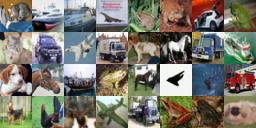

Reconstruction:


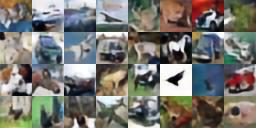

In [ ]:
print("Original:")
display(IPImage("true.jpg"))
print("Reconstruction:")
display(IPImage("recon.jpg"))

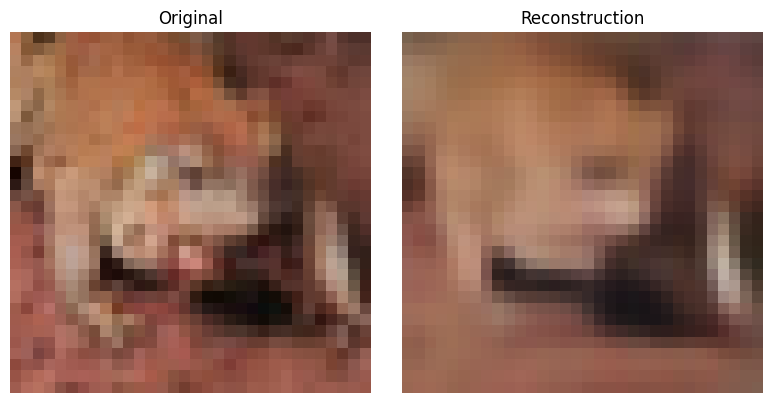

In [ ]:
#@title one image for clarity
model.eval()
with torch.no_grad():
    sample_imgs, _ = next(iter(test_loader))
    sample_imgs = sample_imgs.to(DEVICE)
    recon_imgs  = model(sample_imgs)["x_recon"]

idx = 5
input_img = sample_imgs[idx].cpu().permute(1, 2, 0).clamp(0, 1)
recon_img = recon_imgs[idx].cpu().permute(1, 2, 0).clamp(0, 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(input_img)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(recon_img)
plt.title("Reconstruction")
plt.axis("off")

plt.tight_layout()
plt.show()